# Проектная работа
## Автоматический обработчик excel-таблиц
## И анализ полученной информации по заболеваемости и смертности населения России от злокачественных новообразований
_____
**Описание проекта.**
Достаточно частая задача практически в любой фирме — это работа с множеством однотипных файлов (например, периодических отчетов), из которых надо сделать сводную информацию для руководства: отчет или дашборд. Если такого рода задача носит постоянный характер, то есть смысл этот процесс автоматизировать: сделать универсальный обработчик, который будет обрабатывать файлы без участия человека и сохранять обработанный результат в том или ином виде: обработанная таблица или дашборд.

_____
**Задачи проекта.**
Создать обработчик для данных (автоматизация рутинных операций), выгрузить обработанные данные в гугл таблицу и провести исследовательский анализ данных.
 

**Этапы проекта:** 
> &nbsp;
> Загрузка и обработка данных
> 1. Загрузить данные:
> >  * Подключиться к Яндекс диску
> >  * Создать список файлов для загрузки через списочное выражение: использование os.chdir(), os.listdir(), str.endswith()
> >  * Определить количество типов таблиц в файлах
> >  * Определить методы извлечения необходимых данных
> >  * Написать обработчик полученных excel-файлов
> >  * Получить на выходе список датасетов
> >  * Проверить корректность загрузки
> >  * Слить датасеты в один 
> >  * Дообработать данные (при необходимости): колонки, типы данных, пробелы и прочие недочеты
> >  * Сохранить очищенные данные в таблицу Google sheets

> Аналитическая часть

> 2.  Предварительная обработка данных
> >  * Создать отдельный столбец с  Федеральным округом
> >  * Оставить в столбце Республика/край/область только названия областей, республик, краев
> >  * В локализации удалить индекс болезни
> >  * В типе информации оставить только Заболеваемость или Смертность
> 3. EDA
> >  * Создать сводную таблицу для каждого региона и каждого заболевания вывести заболеваемость  и смертность (абсолютные показатели)
> >  * Визуализировать ТОП 10 регионов по заболеваемости
> >  * Добавить данные  об общей смертности в 2021 году  https://rosstat.gov.ru/folder/210/document/13204.?print=1  =для каждого субъекта РФ и проанализировать процент смертности от онкозаболеваний
> >  * Проанализировать соотношение мужчин и женщин в структуре онкозаболеваний и смертности от онкозаболеваний
> >  * Сделать дашборд (опционально)
> &nbsp;<br><br>

1. [**Открытие данных**](#start)

2. [**Загрузка и предобработка данных**](#prep)

3. [**EDA**](#analysis)
       
4. [**Выводы**](#end)


### Открытие данных<a id='start'></a>

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import os
!pip install yadisk
from tqdm import tqdm
from openpyxl import load_workbook
import numpy as np
import re
from fo_regions import regions_in_federal

import sys
import yadisk

from cfg import app_id, secret_id, ya_token

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Загрузка и предобработка данных<a id='prep'></a>

Получаем токен и выгружаем таблицы

In [2]:
y = yadisk.YaDisk(app_id, secret_id, ya_token)

In [3]:
list_of_files = []
for el in list(y.listdir('file_processor')):
    if el['path'].endswith('.xlsx'):
        list_of_files.append(el['path'])

In [4]:
load_path = "/file_processor/"
if not os.path.exists(load_path):
    os.mkdir(load_path)

In [5]:
os.chdir("/file_processor/")

In [6]:
for file in tqdm(list_of_files):
    if file.split('/')[-1] not in os.listdir():
        y.download(file.split('/')[-1])
    else:
        pass

100%|██████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 4697.98it/s]


Выбираем по номерам и разделяем номера нужных таблиц по спискам

In [7]:
files_list_one = [58] + list(range(61, 86))
files_list_two = [24] + list(range(27, 52))
files_list_three = list(range(12, 36)) + list(range(45, 65)) + list(range(69, 87)) + list(range(93, 104))
files_list_small = list(range(36, 45)) + list(range(87, 93))

In [8]:
for file_list in [files_list_one, files_list_two, files_list_three, files_list_small]:
    for i in range(len(file_list)):
        element = str(file_list[i])
        if len(element) == 1:
            file_list[i] = '00' + element
        elif len(element) == 2:
            file_list[i] = '0' + element
    else:
        pass

In [9]:
convert_one = []
convert_two = []
convert_three = []
convert_small = []

Добавляем таблицы в переменные по номерам в списках

In [10]:
for file in os.listdir():
    if str(file.split('_')[2]) in files_list_one and 'Сос' in file:
        convert_one.append(file)
    elif str(file.split('_')[2]) in files_list_two and 'Сос' in file:
        convert_two.append(file)
    elif str(file.split('_')[2]) in files_list_three and 'Зло' in file:
        convert_three.append(file)
    elif str(file.split('_')[2]) in files_list_small and 'Зло' in file:
        convert_small.append(file)
    else:
        pass

In [11]:
final_one = []
final_two = []
second_sheets = []
final_three = []
men = []
women = []
final_small = []

Обрабатываем первую часть таблиц циклом: редактируем названия колонок, обавляем новые и сохраняем в переменную

In [12]:
for el in tqdm(convert_one):
    vars = load_workbook(el).active['A1'].value.split('  ')
    ind, loc = ' '.join(vars[0].split('\n')[0:2]).capitalize(), vars[0].split('\n')[2]
    table = vars[-1].strip()
    df = pd.read_excel(el, header=[2])
    df.columns = ['Регион',
                  'Число ЗНО, выявленных в отчетном году, радикальное лечение которых закончено в отчетном году, чел.',
                  'Число ЗНО, выявленных в отчетном году, радикальное лечение которых закончено в отчетном году, % от впервые выявленных',
                  'Число ЗНО, выявленных в отчетном году, радикальное лечение которых будет продолжено в отчетом году, чел.',
                  'Число ЗНО, выявленных в отчетном году, радикальное лечение которых будет продолжено в отчетном году, % от впервые выявленных',
                  'В том числе с использованием методов только хирургического, %',
                  'В том числе с использованием методов только лучевого, %',
                  'В том числе с использованием методов только лекарственного, %',
                  'В том числе с использованием методов комбинированного или комплексного (кроме химиолучевого), %',
                  'В том числе с использованием методов химиолучевого, %']
    df['Индикатор'] = ind
    df['Локализация'] = loc
    df['Таблица'] = table
    df['Тип данных'] = 'СОП'
    final_one.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.53it/s]


In [13]:
final_one_df = pd.concat(final_one)

В этих таблицах есть также вторые страницы, которые мы обрабатываем не так как первые, поскольку в них другая информация с другими колонками:

In [14]:
for el in tqdm(convert_two):
    xls = pd.ExcelFile(el)
    vars_2 = load_workbook(el).active['A1'].value.split('  ') 
    ind, loc = ' '.join(vars_2[0:2]).capitalize().split('\n')[0], vars_2[1].split('\n')[-1]
    table = vars_2[-1]
    if 'КОНТ' in loc:
        loc = ' '.join(vars_2).split('\n')[1]
    elif loc == '':
        loc = 'Злокачественные новообразования - всего (С00-96)'
    else:
        pass
    df = pd.read_excel(el, header=[2])
    df.columns = ['Регион',
                  'Взято на учет больных с впервые в жизни установленным диагнозом ЗНО',
                  'в т.ч. выявлены активно (%)',
                 'Находились на учете на конец года, абсолютное число',
                 'Находились на учете на конец года,  на 100 тыс. населения',
                 'из них 5 лет и более, абсолютное число',
                 'из них 5 лет и более, % от состоящих на учете',
                 'Индекс накопления контингентов',
                 'Летальность, %']
    df['Индикатор'] = ind
    df['Локализация'] = loc
    df['Таблица'] = table
    df['Тип данных'] = 'СОП'
    final_two.append(df)
    if 'Table 3' in xls.sheet_names:
        df2 = pd.read_excel(el, sheet_name='Table 3', skiprows=1, header=[2])
        df2.columns = ['Регион',
                          'Зарегистриро- вано ЗНО (без учтенных посмертно)',
                          'из них диагноз подтвержден морфологически, %',
                          'из них имели стадию заболевания, % I',
                          'из них имели стадию заболевания, % II',
                          'из них имели стадию заболевания, % III',
                          'из них имели стадию заболевания, % IV',
                          'из них имели стадию заболевания, % не установлена',
                          'Летальность на первом году с момента уст. диагноза, %']
        df2['Индикатор'] = ind
        df2['Локализация'] = loc
        df2['Таблица'] = table
        df2['Тип данных'] = 'СОП'
        second_sheets.append(df2)   

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:19<00:00,  1.34it/s]


In [15]:
final_two_df = pd.concat(final_two)
fin_sec_sheets = pd.concat(second_sheets)

In [16]:
for table in final_two_df, fin_sec_sheets:
    table['Таблица'] = table['Таблица'].astype(str).apply(
    lambda x: 'Таблица 32' if ' '.join(re.findall(r'(Таблица \d+|Продолжение таблицы \d+)', x)) == '' 
    else ' '.join(re.findall(r'(Таблица \d+|Продолжение таблицы \d+)', x)))

Здесь есть колонки с показателями отдельно для мужчин, женщин и обоих полов. Разделим таблицы на три переменных, чтобы потом склеить их, сразу назовем 4 колонки одинаково

In [17]:
for el in tqdm(convert_three):
    wb = load_workbook(el)
    ws = wb.active
    cell = [ws['A1'].value, ws['A2'].value, ws['B3'].value, ws['A4'].value, ws['B4'].value, ws['A3'].value]
    loc = str(cell[4]) if cell[4] is not None else ''
    if loc == '':
        loc = cell[3].split(': ')[-1]
    year = cell[2] if cell[2] is not None else ''
    if year =='':
        year = cell[5].split(': ')[-1]
        
    df = pd.read_excel(el, skiprows=6, header=[0])
    df.columns = ['Регион',
                'Абсолютное число',
                'Показатель на 100 тыс. населения, "грубый"',
                'Показатель на 100 тыс. населения, стандартизованный',
                'Показатель на 100 тыс. населения, ошибка',
                'Абсолютное число',
                'Показатель на 100 тыс. населения, "грубый"',
                'Показатель на 100 тыс. населения, стандартизованный',
                'Показатель на 100 тыс. населения, ошибка',
                'Абсолютное число',
                'Показатель на 100 тыс. населения, "грубый"',
                'Показатель на 100 тыс. населения, стандартизованный',
                'Показатель на 100 тыс. населения, ошибка']
    df['Пол'] = 'оба пола'
    df['Год'] = year
    df['Индикатор'] = ''.join(cell[1]).capitalize().strip()
    df['Локализация'] = loc
    df['Таблица'] = cell[0]
    df['Тип данных'] = 'ЗНО'
    final_three.append(df.iloc[:,[0,1,2,3,4,13,14,15,16,17,18]])
    men.append(df.iloc[:,[0,5,6,7,8,13,14,15,16,17,18]])
    women.append(df.iloc[:,[0,9,10,11,12,13,14,15,16,17,18]])

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:57<00:00,  1.11it/s]


In [18]:
final_three_df = pd.concat(final_three)
men = pd.concat(men)
women = pd.concat(women)

In [19]:
women['Пол'] = 'женский'
men['Пол'] = 'мужской'

In [20]:
for el in tqdm(convert_small):
    wb = load_workbook(el)
    ws = wb.active
    cell = [ws['A1'].value, ws['A2'].value, ws['B3'].value, ws['A4'].value, ws['A5'].value, ws['B4'].value]
    
    df = pd.read_excel(el, skiprows=5,header=[0])
    df.columns = ['Регион',
                'Абсолютное число',
                'Показатель на 100 тыс. населения, "грубый"',
                'Показатель на 100 тыс. населения, стандартизованный',
                'Показатель на 100 тыс. населения, ошибка']
    df['Пол'] = ''
    if '51' in cell[5] or '52' in cell[5] or '53' in cell[5] or '54' in cell[5] or '56' in cell[5] or '58' in cell[5]:
        df['Пол'] = 'женский'
    elif '60' in cell[5] or '61' in cell[5] or '62' in cell[5] or '63' in cell[5]:
        df['Пол'] = 'мужской'
    df['Год'] = cell[2]
    df['Индикатор'] = ''.join(cell[1]).capitalize()
    df['Локализация'] = cell[5]
    df['Таблица'] = cell[0]
    df['Тип данных'] = 'ЗНО'
    final_small.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.12it/s]


In [21]:
final_small_df = pd.concat(final_small)

Склеиваем основные полученные таблицы в одну, с которой далее и будем работать при анализе:

In [22]:
fin = pd.concat([final_three_df, final_small_df, men, women])

In [23]:
fin['Регион'] = fin['Регион'].str.strip()

Добавим в полученные таблицы колонку с округом, определенным на основе информации по регионам:

In [24]:
dataframes = ['fin', 'final_one_df', 'final_two_df', 'fin_sec_sheets']

for df_name in dataframes:
    df = globals()[df_name]

    regions_to_federal = {region: federal for federal, regions in regions_in_federal.items() for region in regions}
    df['Регион'] = df['Регион'].fillna('unknown').astype('str')    
    bad_regions = df[df.Регион.str.upper().str.contains('ФО|РОССИЯ')]['Регион'].tolist()
    df = df.loc[~df['Регион'].isin(bad_regions)]
    df['Округ'] = df['Регион'].map(regions_to_federal)
    df = df[['Округ'] + [x for x in df.columns if x != 'Округ']]
    
    globals()[df_name] = df

Сохраняем все обратно в excel

In [25]:
final_one_df.to_excel('58_82_SOP.xlsx', index=False)
final_two_df.to_excel('24_51_SOP_1.xlsx', index=False)
fin_sec_sheets.to_excel('24_51_SOP_2.xlsx', index=False)
fin.to_excel('12_103_ZNO.xlsx', index=False)

### EDA<a id='analysis'></a>

Оставим в датафрейме только интересующие нас колонки, и в регионах только те значения, которые содержат слова "область", "обл.", "Республика", "край", "Респ.".

In [26]:
fin = fin.iloc[:,[0,1,2,6,8,9]]

In [27]:
regs = ['область','обл.','Республика','край','Респ.']
pattern = "|".join(regs)
fin = fin[fin['Регион'].str.contains(pattern, case=False, na=False)]

В "Локализации" удалим номер болезни, и в "Индикаторе" оставим только первое слово - у нас это Заболеваемость и Смертность

In [28]:
fin['Локализация'] = fin['Локализация'].astype('str').str.split(' \(').apply(lambda x: ' '.join(x[0:-1])).str.strip('/)')
fin['Индикатор'] = fin['Индикатор'].astype('str').str.split(' ').str[0]

Выведем 10 регионов с самой высокой заболеваемостью и визуализируем это с помощью графика:

In [29]:
fin[fin['Индикатор']=='Заболеваемость'].groupby('Регион')['Абсолютное число']\
                                       .agg('sum').reset_index().sort_values(by='Абсолютное число',ascending=False)[:10]

,Регион,Абсолютное число
27,Московская область,101752
20,Краснодарский край,93905
66,Свердловская область,78023
55,Республика Татарстан,64904
29,Нижегородская область,64042
76,Челябинская область,61336
63,Самарская область,55873
61,Ростовская область,55070
21,Красноярский край,49095
7,Волгоградская область,45539


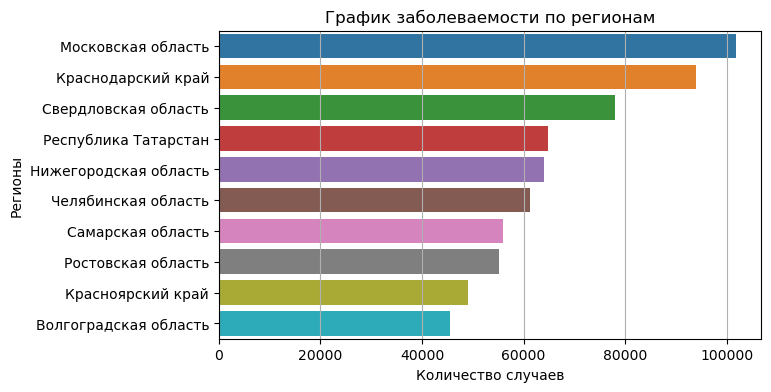

In [30]:
top_10 = fin[fin['Индикатор']=='Заболеваемость']\
.groupby('Регион')['Абсолютное число'].agg('sum')\
.reset_index().sort_values(by='Абсолютное число',ascending=False)[:10]

plt.figure(figsize=(7, 4))
sns.barplot(data=top_10,y='Регион', x='Абсолютное число', estimator=sum).grid(axis='x')

plt.ylabel('Регионы')
plt.xlabel('Количество случаев')
plt.title('График заболеваемости по регионам')
plt.show()

По графику видно, что на первом месте находитмся Московская область - больше 100 000 случаев. На втором месте Краснодарский край - приближается к этой цифре.

В остальных регионах зафиксировано менее 80 000 случаев, наименьшее по количеству - около 45 000 - Волгоградская область.

Добавим данные о смертности в регионах за 2021г., скачанные с сайта [Федеральной службы государственной статистики](https://rosstat.gov.ru/folder/210/document/13204)

In [31]:
deaths = pd.DataFrame(pd.read_excel(r'C:\Users\admin\Documents\Projects\File Processor\deaths.xlsx', header=2))

deaths = deaths.iloc[:,[0,-1]]
deaths.columns = ['Регион', 'смертность_2021']
deaths['Регион'] = deaths['Регион'].str.replace('\n',' ')

Создадим сводную таблицу с процентом смертности от онкозаболеваний по нашему датафрейму, и добавим в нее данные о смертности в 2021г. с сайта. Отсортируем по колонке со смертностью в 21м году, и оставим топ-10 регионов.

In [32]:
perc = fin.pivot_table(index=['Регион','Локализация','Пол'],\
                       columns='Индикатор',values='Абсолютное число',aggfunc='sum').reset_index()\
.groupby(['Регион'])['Смертность','Заболеваемость']\
.agg({'Смертность':'sum','Заболеваемость':'sum'}).round(2).reset_index()\
.sort_values(by='Заболеваемость',ascending=False)
perc['% онко-смертности'] = (perc['Смертность'] / perc['Заболеваемость']*100).round(1)

In [33]:
top = perc.merge(deaths, on='Регион', how='right')
top = top.dropna()
top = top.sort_values(by=['смертность_2021'],ascending=False)[:10]
top = top.sort_values(by=['смертность_2021'],ascending=True)

Визуализируем получившуюся таблицу:

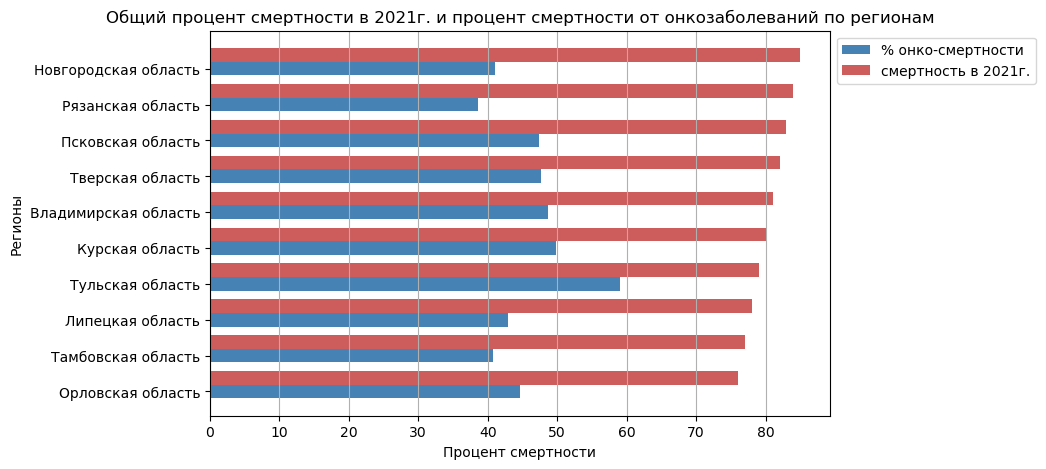

In [34]:
plt.figure(figsize=(8, 5))

barHeight = 0.38

y_pos = np.arange(len(top["% онко-смертности"]))
plt.barh(y_pos, top["% онко-смертности"], height=barHeight, color='steelblue')

y_pos = [y + barHeight for y in y_pos]
plt.barh(y_pos, top["смертность_2021"], height=barHeight, color='indianred')

plt.ylabel('Регионы')
plt.xlabel('Процент смертности')
plt.yticks(np.arange(len(top["% онко-смертности"])), top['Регион'])
plt.legend(['% онко-смертности', 'смертность в 2021г.'],bbox_to_anchor=(1,1))
plt.title('Общий процент смертности в 2021г. и процент смертности от онкозаболеваний по регионам')
plt.grid(axis='x')

plt.show()

По графику видно, что самый большой % смертности среди всех регионов в 2021 году был в Новгородской области, а смертность от онкозаболеваний в этом регионе - чуть больше 40%.

Внимание привлекает Тульская область - первая по смертности от онко-заболеваний - почти 60%, учитывая что общий процент смертности едва не доходит до отметки 80.

Визуализируем соотношение мужчин и женщин по заболеваемости и смертности:

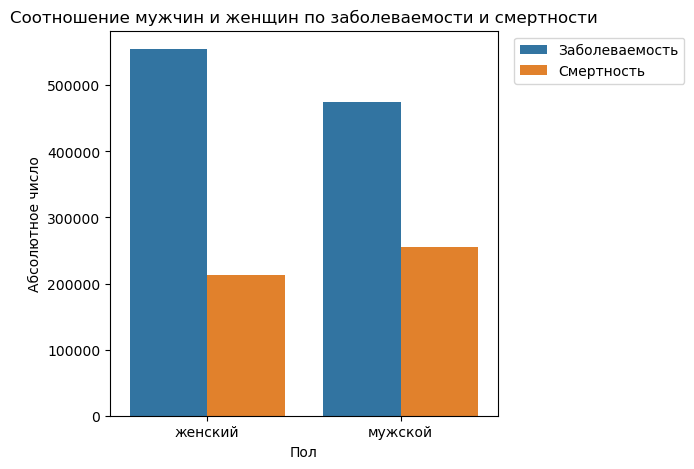

In [35]:
plt.figure(figsize=(5, 5))
sns.barplot(data=fin[fin['Пол'] != 'оба пола']\
            .groupby(['Пол','Индикатор'])['Абсолютное число'].agg('sum').reset_index(),
           x='Пол',y='Абсолютное число',hue='Индикатор')
plt.legend(bbox_to_anchor=(1.5,1))
plt.title('Соотношение мужчин и женщин по заболеваемости и смертности')
plt.show();

Видно, что болеющих женщин больше, чем мужчин. А по смертности мужчин чуть больше, чем женщин.

Посмотрим на распределение заболеваемости и смертности среди мужчин и женщин по локализациям. Разделим атафрейм на два по половому признаку:

In [36]:
men = fin[fin['Пол'] == 'мужской'].groupby(['Индикатор', 'Локализация'])['Абсолютное число']\
                                  .agg('sum').reset_index().sort_values('Абсолютное число',ascending=False)
women = fin[fin['Пол'] == 'женский'].groupby(['Индикатор', 'Локализация'])['Абсолютное число']\
                                    .agg('sum').reset_index().sort_values('Абсолютное число',ascending=False)

Визуализируем полученные результаты, сначала посмотрим на наивысшие показатели по мужчинам:

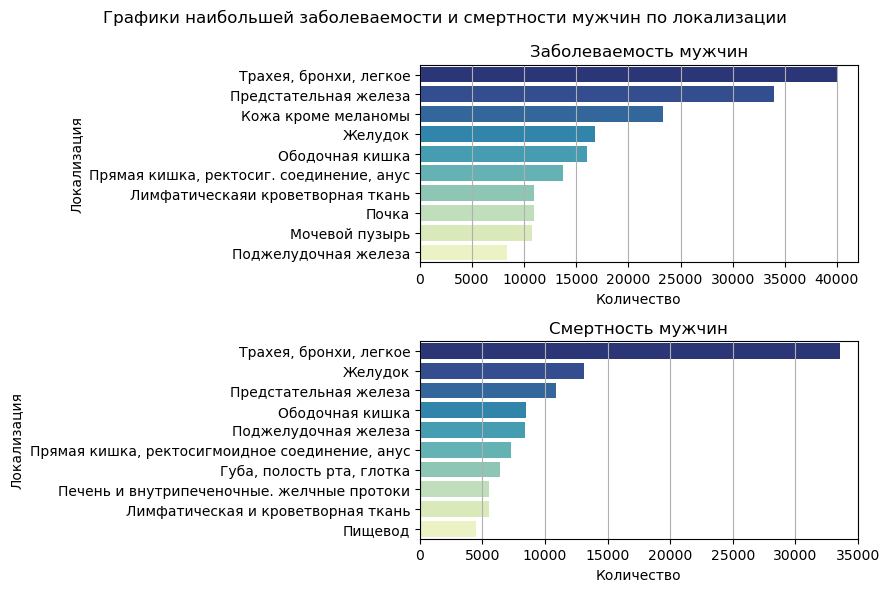

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

for ax in axes:
    ax.xaxis.grid(True)
    
fig.suptitle('Графики наибольшей заболеваемости и смертности мужчин по локализации')

sns.barplot(ax=axes[0], data=men[men['Индикатор']=='Заболеваемость'][1:11],
            x='Абсолютное число',
            y='Локализация',
           palette='YlGnBu_r')\
                .set(xlim=(0,42000), title='Заболеваемость мужчин', xlabel='Количество', ylabel='Локализация')
sns.barplot(ax=axes[1], data=men[men['Индикатор']=='Смертность'][1:11],
            x='Абсолютное число',
            y='Локализация',
           palette='YlGnBu_r')\
                .set(xlim=(0,35000), title='Смертность мужчин', xlabel='Количество', ylabel='Локализация')
plt.tight_layout()
plt.show();

По графику видно, что среди мужчин и заболеваемость, и смертность наибольшая по локализации "Трахея, бронхи, легкое". Вероятнее всего, это курильщики. Далее показатели расходятся, но можно увидеть, что наиболее опасными локализациями для мужчин являются "Предстательная железа" и "Желудок".

Построим такие же графики по датафрейму с женщинами:

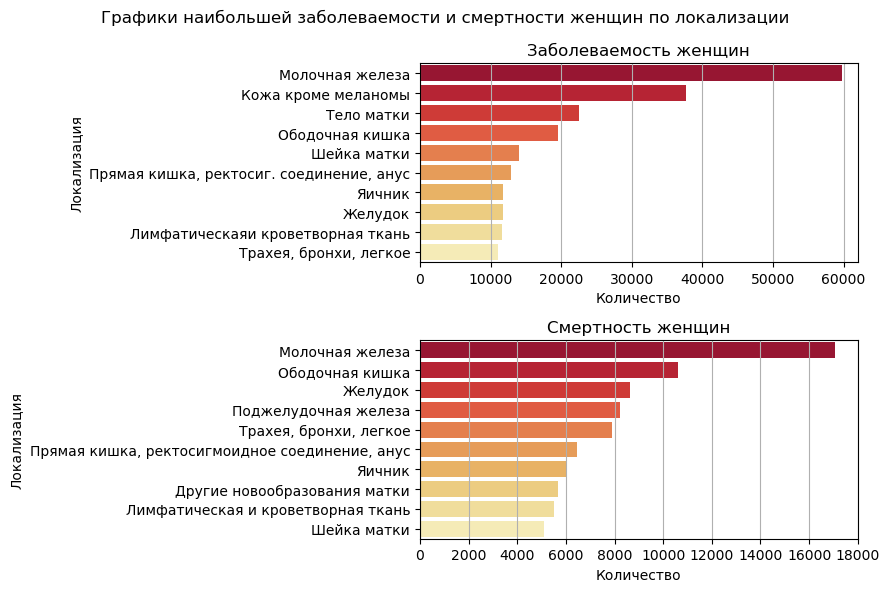

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

for ax in axes:
    ax.xaxis.grid(True)
    
fig.suptitle('Графики наибольшей заболеваемости и смертности женщин по локализации')

sns.barplot(ax=axes[0], data=women[women['Индикатор']=='Заболеваемость'][1:11],
            x='Абсолютное число',
            y='Локализация',
           palette='YlOrRd_r')\
                .set(xlim=(0,62000), title='Заболеваемость женщин', xlabel='Количество', ylabel='Локализация')
sns.barplot(ax=axes[1], data=women[women['Индикатор']=='Смертность'][1:11],
            x='Абсолютное число',
            y='Локализация',
           palette='YlOrRd_r')\
                .set(xlim=(0,18000), title='Смертность женщин', xlabel='Количество', ylabel='Локализация')
plt.tight_layout()
plt.show();

В отношении женщин самой опасной локализацией и по заболеваемости, и по смертности стала "Молочная железа", также опасность представляют "Ободочная кишка", "Тело матки", "Желудок".

### Выводы<a id='end'></a>

В итоговом общем выводе по проекту с анализом данных по онкозаболеваниям можно отметить следующее:

На основании проведенного анализа было выявлено, что Московская область и Краснодарский край являются регионами с самой высокой заболеваемостью онкологическими заболеваниями, где количество случаев превышает 100 000. В остальных регионах количество случаев заболеваний составляет менее 80 000, при этом наименьшее количество случаев (около 45 000) зафиксировано в Волгоградской области.

Также были добавлены данные о смертности от онкозаболеваний в регионах за 2021 год, полученные с сайта Федеральной службы государственной статистики. По данным графика, выявлено, что самый высокий процент смертности от онкологических заболеваний в 2021 году был отмечен в Новгородской области, составляющий чуть больше 40%. Тульская область оказалась первой по смертности от онкозаболеваний, где этот показатель практически достигает отметки в 60%, суммарная смертность в данном регионе почти доходит до 80%.

Анализ также показал, что количество заболевших женщин превышает количество заболевших мужчин. По данным графика, наибольшее количество онкологических заболеваний среди мужчин отмечено в локализациях "Трахея, бронхи, легкое", "Предстательная железа" и "Желудок". Это может быть связано с привычкой курения. У женщин самой опасной локализацией заболеваний оказалась "Молочная железа", также значимыми локализациями являются "Ободочная кишка", "Тело матки" и "Желудок".

Таким образом, полученные результаты анализа данных по онкозаболеваниям позволяют выделить основные регионы с высокой заболеваемостью и выявить группы населения с наибольшим риском заболеваний, что может служить основой для разработки и реализации мероприятий по профилактике и борьбе с онкологическими заболеваниями в различных регионах страны.